# Project Summary:

The goal of the project is 
1. explore what factors lead to the variation in the yields reported by the farmer.
2  To build a model to predict the yield associated with a given sample. 
3. Report any other data stories and/or oddities you encounter.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [8]:
import re
from sklearn.preprocessing import Imputer

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Report

#No duplicates on sample_id and taxonomic_string_id. 8154 taxonomic string ids (at all taxonomic levels) and 160 sample id's farmers' samples.

Yield statistics and the produce.
1. Among samples, the mean of crop yields is 672.80625 with std=173. The yield is not  a Normal distribution, with an outlier/anomoly peak at 800 heads of produce. The crops have 3 kinds 'lettuce_romaine', 'lettuce_iceburg', nan, 'spinach'. 6% NaN value is small (not included).  Among lettuce_iceburg 160 samples, 
lettuce_iceburg    108
lettuce_romaine     41
spinach              1

Minor Comment: Soil sample dates are winter but some are in spring. 
['12/3/2016' '11/29/2016' '11/28/2016' '12/06/2016' '1/12/2017'
 '12/27/2017' '01/12/2018' '4/10/2018' '5/24/2018']
 
Minor Comment: Since subfield names/code are too similar to each other, many samples may have come from the same
farmer who own the same lot.

Factors that may contribute to the yield 
2. We want to explore what factors in metadata lead to variations in the yield. For many categorical variables,
We run to figure out which categorical variables will be related to the yields. We prrform chi2_contingency test to understand the independecy of those categories on the yield. For categorical variables: soil_depth	land_performance,planting date did not provide a strong chi2 score. We cannot our Null Hypothesis which is these features are independent and have no relationship with target variable. These factors may not be strong predictors.


Understand the DNA (microbiome) info in the soil sample for each produce
3. We also want to see how the  yield will depends on the DNA compositions in microbiomes in the soil.  Accroding to Taxonomic rank: (Domain, Kingdom, Phylum, Class, Order, Family, Genus, Species), the otu_hits data 8154 DNA sequences has 18 levels and these DNA sequences can be mapped into multiple organisms (not unqiues) (species or subspecies). Also a majority of data (7103 DNAs) have no Rank. It can be possibly due to novel mutated species, or the strain is too short to identify to be classfied.  

We will need to deterimne what level of Taxonomic rank has most predictive power (or related to the 
class, species, suborder, subspecies). We will initially focus on (A) 15 Species Group -> (B) 4 Species subgroup (C) 500 Species (D) 4 Subspecies, since it provides the lower level details of the DNA information.  

Our initial try is to try a simple regression and classification model to see if we can predict the yields based on (A)-(D). Since there are three kinds of produce, and certain DNAs (therefore certain microbiomes) may be more beneficial for certtain vegetables, we can apply the yield for different vegetables. 


4. Further Analysis on DNA samples. For 500 DNA Species, for one produce Lettuce iceberge, (the percentage of the DNA sequences is not necessarily normalized at DNA sepecies levels are normalized, so analysis included normalization). 



# Summary

1. categorial features (farming method,  related to the farming did not show much relationship on the yield according to chi2 test, possibly except land performace (p=0.08852112357603432).  Interaction of those categorial variables was not looked at yet. 

2. For DNA analysis, At species level, regression to predict the yield for each produce (different types of lettuce) did not get good results. The total sample size is too small (possibly from a few farmers). We can look at the 15 Species Group in the future.  

3. At species level, the prediction for the bad crop (to reduce the farmer's loss) for the crop yield (less than 550) as a classification problem has alittle higher than 56% than random chance prediction.  Some of the DNA species deserve further investigation.  


'species__Kosakonia sacchari;genus__Kosakonia;family__Enterobacteriaceae;order__Enterobacterales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms',
       
'species__Cellulosimicrobium cellulans;genus__Cellulosimicrobium;family__Promicromonosporaceae;order__Micrococcales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms',

'species__Fusarium avenaceum;no rank__Fusarium tricinctum species complex;genus__Fusarium;family__Nectriaceae;order__Hypocreales;subclass__Hypocreomycetidae;class__Sordariomycetes;no rank__sordariomyceta;no rank__leotiomyceta;subphylum__Pezizomycotina;no rank__saccharomyceta;phylum__Ascomycota;subkingdom__Dikarya;kingdom__Fungi;no rank__Opisthokonta;superkingdom__Eukaryota;no rank__cellular organisms

5. 15 Species Group (Instead of 500 Species) can be further looked at. 
 
4. Due to the small sample size, more data can be useuful. Or Maybe we can look at other methods that may be good for a small sample sets. 

# Data Import and examine

In [12]:
df_meta = pd.read_csv('metadata.csv')
df_hits=pd.read_csv('otu_hits.csv')

In [26]:
df_meta=df_meta.rename(columns={"yield ((boxes of 24 heads of lettuce)/acre)": "yields"})
df_meta.head()

,sample_id,sampling_date,soil_depth,land_performance,current_crop,previous_crop,production_type,extraction_date,subfield_name,planting_date,yields
0,sample_001,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 healthy,NaN,878
1,sample_002,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,568
2,sample_003,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,432
3,sample_004,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,449
4,sample_005,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 502 not healthy,NaN,532


In [ ]:
# To see all unique values in the data.

In [64]:
for i in list(df_meta):
    print(i, df_meta[i].unique())

sample_id ['sample_001' 'sample_002' 'sample_003' 'sample_004' 'sample_005'
 'sample_006' 'sample_007' 'sample_008' 'sample_009' 'sample_010'
 'sample_011' 'sample_012' 'sample_013' 'sample_014' 'sample_015'
 'sample_016' 'sample_017' 'sample_018' 'sample_019' 'sample_020'
 'sample_021' 'sample_022' 'sample_023' 'sample_024' 'sample_025'
 'sample_026' 'sample_027' 'sample_028' 'sample_029' 'sample_030'
 'sample_031' 'sample_032' 'sample_033' 'sample_034' 'sample_035'
 'sample_036' 'sample_037' 'sample_038' 'sample_039' 'sample_040'
 'sample_041' 'sample_042' 'sample_043' 'sample_044' 'sample_045'
 'sample_046' 'sample_047' 'sample_048' 'sample_049' 'sample_050'
 'sample_051' 'sample_052' 'sample_053' 'sample_054' 'sample_055'
 'sample_056' 'sample_057' 'sample_058' 'sample_059' 'sample_060'
 'sample_061' 'sample_062' 'sample_063' 'sample_064' 'sample_065'
 'sample_066' 'sample_067' 'sample_068' 'sample_069' 'sample_070'
 'sample_071' 'sample_072' 'sample_073' 'sample_074' 'sample_075'


In [46]:
df_meta['current_crop'].unique()

array(['lettuce_romaine', 'lettuce_iceburg', nan, 'spinach'], dtype=object)

In [18]:
df_meta.shape

(160, 11)

In [43]:
df_hits.shape

(8154, 162)

In [24]:
df_hits.head(3)

,taxonomic_string_id,sample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007,sample_008,sample_009,...,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160
0,class__Actinobacteria;phylum__Actinobacteria;n...,0.278240,0.345916,0.252930,0.294848,0.283003,0.242064,0.205965,0.253730,0.248714,...,0.251851,0.196867,0.0,0.0,0.182708,0.213147,0.588762,0.588704,0.185188,0.449854
1,class__Agaricomycetes;subphylum__Agaricomycoti...,0.023063,0.003198,0.009754,0.009214,0.003326,0.004978,0.005175,0.006736,0.008633,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000653,0.000000,0.000000
2,class__Alphaproteobacteria;phylum__Proteobacte...,0.056541,0.087412,0.066259,0.062404,0.022979,0.025513,0.018975,0.058380,0.056320,...,0.265543,0.169840,0.0,0.0,0.140805,0.086192,0.511583,0.651360,0.418327,0.589054


In [39]:
df_hits['taxonomic_string_id'].head(3)

0    class__Actinobacteria;phylum__Actinobacteria;n...
1    class__Agaricomycetes;subphylum__Agaricomycoti...
2    class__Alphaproteobacteria;phylum__Proteobacte...
Name: taxonomic_string_id, dtype: object

In [42]:
import re
def get_levels(s):
    return s.split('_')[0]

df_hits['taxonomic_level']=df_hits['taxonomic_string_id'].map(get_levels)
df_hits.head()
df_hits.groupby('taxonomic_level').count()

,taxonomic_string_id,sample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007,sample_008,sample_009,...,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160
taxonomic_level,,,,,,,,,,,,,,,,,,,,,
class,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
family,91,91,91,91,91,91,91,91,91,91,...,91,91,91,91,91,91,91,91,91,91
forma,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
genus,326,326,326,326,326,326,326,326,326,326,...,326,326,326,326,326,326,326,326,326,326
kingdom,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
no rank,7103,7103,7103,7103,7103,7103,7103,7103,7103,7103,...,7103,7103,7103,7103,7103,7103,7103,7103,7103,7103
order,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
phylum,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
species,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500


In [19]:
df_hits.shape

(8154, 161)

In [34]:
df_meta['yields'].mean()
df_meta['yields'].std()

173.55359119677013

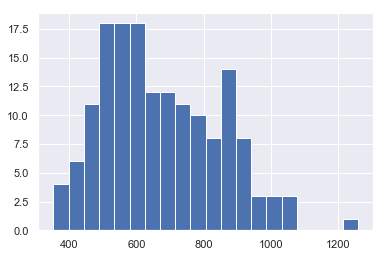

In [27]:
# yield distribution among samples
df_meta['yields'].hist(bins=20)

In [66]:
#df=df_hits
#columns=list(df)
#columns

In [15]:
df_meta.dtypes

sample_id                                      object
sampling_date                                  object
soil_depth                                     object
land_performance                               object
current_crop                                   object
previous_crop                                  object
production_type                                object
extraction_date                                object
subfield_name                                  object
planting_date                                  object
yield ((boxes of 24 heads of lettuce)/acre)     int64
dtype: object

In [ ]:
# To check missing values and the percentage
#df_hits.dtypes all float64

In [23]:
df=df_hits
df=df_meta

def check_frame_messiness(df):
    column=list(df)

    print(df.info(),'df-info')
    print('')
    
    print(sum(df['sample_id'].duplicated()), ' duplicates')
    print('')
    
    print(df[column].isnull().sum()/len(df[column]),'Null')
    print(df[column].isna().sum()/len(df[column]),'NaN')
    filter=df[column]=='Not Available'
    print(df[column][filter].sum(),'Not Available')

check_frame_messiness(df)      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 11 columns):
sample_id                                      160 non-null object
sampling_date                                  160 non-null object
soil_depth                                     152 non-null object
land_performance                               152 non-null object
current_crop                                   150 non-null object
previous_crop                                  1 non-null object
production_type                                152 non-null object
extraction_date                                73 non-null object
subfield_name                                  160 non-null object
planting_date                                  3 non-null object
yield ((boxes of 24 heads of lettuce)/acre)    160 non-null int64
dtypes: int64(1), object(10)
memory usage: 13.8+ KB
None df-info

0  duplicates

sample_id                                      0.00000
sampling_date               

In [47]:
def plot_df_stats_categories(df_input,col_1,col_2,x_fontsize,x_angle):
    
    df_output = pd.DataFrame(columns=['MEAN', 'sem'])
    df_output['MEAN'] = df_input.groupby(col_1)[col_2].mean()
    df_output['sem'] = df_input.groupby(col_1)[col_2].sem()
    df_output=df_output.reset_index()
    
    
    categories = np.sort(df_input[col_1].unique())
    x_pos = np.arange(len(categories))
    CTEs = df_output['MEAN']
    error =df_output['sem']

    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Yield over different produce')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories,rotation = x_angle)
#    ax.set_title('Crop')
    ax.yaxis.grid(True)

    
    plt.rc('xtick',labelsize=x_fontsize)
  
    # Save the figure and show
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

In [61]:
df_meta.groupby('current_crop')['sample_id'].count()

current_crop
lettuce_iceburg    108
lettuce_romaine     41
spinach              1
Name: sample_id, dtype: int64

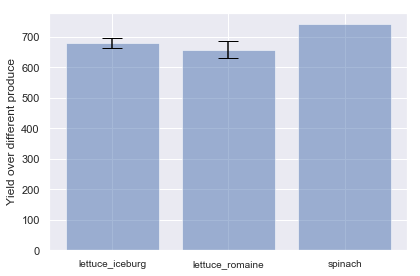

In [60]:
df=df_meta.dropna(subset=['yields','current_crop'])
plot_df_stats_categories(df,'current_crop','yields',5,0)

# Determine which categorical variables are important for the yields:

The categorical data does not provide strong correlation with yields. 

In [65]:
df.head(3)

,sample_id,sampling_date,soil_depth,land_performance,current_crop,previous_crop,production_type,extraction_date,subfield_name,planting_date,yields
0,sample_001,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 healthy,NaN,878
1,sample_002,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,568
2,sample_003,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,432


In [69]:
from scipy.stats import chi2_contingency

def determine_contingency(df_input,factor):    
    df=df_input.dropna(subset=[factor])
    csq=chi2_contingency(pd.crosstab(df['yields'], df[factor]))
    print("P-value: ",csq[1])

In [70]:
df_input=df_meta
factor='land_performance'
determine_contingency(df,factor)

P-value:  0.08852112357603432


In [71]:
df_input=df_meta
factor='soil_depth'
determine_contingency(df,factor)

P-value:  0.16488744796188742


In [72]:
df_input=df_meta
factor='production_type'
determine_contingency(df,factor)

P-value:  0.16488744796188742


In [73]:
df_input=df_meta
factor='planting_date'
determine_contingency(df,factor)

P-value:  0.22313016014842973


# DNA sample analysis for current_crop lettuce_romaine and 'lettuce_iceburg

At 500 Species level and 15 Species Group. 

In [77]:
df_meta.head(3)

,sample_id,sampling_date,soil_depth,land_performance,current_crop,previous_crop,production_type,extraction_date,subfield_name,planting_date,yields
0,sample_001,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 healthy,NaN,878
1,sample_002,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,568
2,sample_003,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,432


In [76]:
df_hits.head()
df_hits[df_hits['taxonomic_level']=='species'].head(4)

,taxonomic_string_id,sample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007,sample_008,sample_009,...,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,taxonomic_level
7627,species__Acanthamoeba lenticulata;genus__Acant...,0.002604,0.0,0.004709,0.003769,0.000000,0.000622,0.00000,0.001796,0.002467,...,0.001001,0.0,0.0,0.000521,0.000608,0.000000,0.001305,0.000000,0.000000,species
7628,species__Achromobacter denitrificans;genus__Ac...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000334,0.0,0.0,0.000000,0.001825,0.001764,0.003263,0.001653,0.002263,species
7629,species__Achromobacter piechaudii;genus__Achro...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.002002,0.0,0.0,0.003774,0.021903,0.003087,0.003263,0.006614,0.004527,species
7630,species__Achromobacter xylosoxidans;genus__Ach...,0.000000,0.0,0.000000,0.000000,0.001209,0.001245,0.00069,0.000000,0.000411,...,0.001668,0.0,0.0,0.000781,0.002839,0.002646,0.006527,0.001653,0.006224,species


In [ ]:
# Transpose the datat for each sample and merge the sample data from df_meta

In [103]:
df_hits_by_species.shape

(500, 162)

In [98]:
df_hits_by_species=df_hits[df_hits['taxonomic_level']=='species'].reset_index(drop=True)
df_hits_by_species_t = df_hits_by_species.transpose().reset_index()
df_hits_by_species_t.columns = df_df_hits_by_species_t.iloc[0]
df_hits_by_species_t=df_hits_by_species_t.reindex(df.index.drop(0))
df_hits_by_species_t=df_hits_by_species_t.rename(columns={"taxonomic_string_id": "sample_id"})
df_hits_by_species_t.head()

,sample_id,species__Acanthamoeba lenticulata;genus__Acanthamoeba;family__Acanthamoebidae;no rank__Centramoebida;order__Longamoebia;no rank__Discosea;no rank__Amoebozoa;superkingdom__Eukaryota;no rank__cellular organisms,species__Achromobacter denitrificans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter piechaudii;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter xylosoxidans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acidipropionibacterium acidipropionici;genus__Acidipropionibacterium;family__Propionibacteriaceae;order__Propionibacteriales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Acidovorax citrulli;genus__Acidovorax;family__Comamonadaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acinetobacter baumannii;species group__Acinetobacter calcoaceticus/baumannii complex;genus__Acinetobacter;family__Moraxellaceae;order__Pseudomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Actinoalloteichus cyanogriseus;genus__Actinoalloteichus;family__Pseudonocardiaceae;order__Pseudonocardiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Actinomadura madurae;genus__Actinomadura;family__Thermomonosporaceae;order__Streptosporangiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,...,species__Xanthomonas gardneri;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas oryzae;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas phaseoli;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas sacchari;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas translucens;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas vesicatoria;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Yangia pacifica;genus__Yangia;family__Rhodobacteraceae;order__Rhodobacterales;class__Alphaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Zymomonas mobilis;genus__Zymomonas;family__Sphingomonadaceae;order__Sphingomonadales;class__Alphaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__bacteria symbiont BFo1 of Frankliniella occidentalis;no rank__unclassified Bacteria (miscellaneous);no rank__unclassified Bacteria;superkingdom__Bacteria;no rank__cellular organisms,species__nitrifying bacterium enrichment culture;no rank__environmental samples;superkingdom__Bacteria;no rank__cellular organisms
1,sample_001,0.00260385,0,0,0,0,0,0.0208308,0,0.000743956,...,0,0.00148791,0,0,0,0,0,0

In [95]:
len(df_meta)

160

In [96]:
len(df_hits_by_species_t)

151

In [104]:
df_merged = pd.merge(df_hits_by_species_t,df_meta,right_index=False,left_index=False, how='inner',on='sample_id')

In [105]:
len(df_merged)

151

In [106]:
df_merged.head()

,sample_id,species__Acanthamoeba lenticulata;genus__Acanthamoeba;family__Acanthamoebidae;no rank__Centramoebida;order__Longamoebia;no rank__Discosea;no rank__Amoebozoa;superkingdom__Eukaryota;no rank__cellular organisms,species__Achromobacter denitrificans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter piechaudii;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter xylosoxidans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acidipropionibacterium acidipropionici;genus__Acidipropionibacterium;family__Propionibacteriaceae;order__Propionibacteriales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Acidovorax citrulli;genus__Acidovorax;family__Comamonadaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acinetobacter baumannii;species group__Acinetobacter calcoaceticus/baumannii complex;genus__Acinetobacter;family__Moraxellaceae;order__Pseudomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Actinoalloteichus cyanogriseus;genus__Actinoalloteichus;family__Pseudonocardiaceae;order__Pseudonocardiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Actinomadura madurae;genus__Actinomadura;family__Thermomonosporaceae;order__Streptosporangiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,...,sampling_date,soil_depth,land_performance,current_crop,previous_crop,production_type,extraction_date,subfield_name,planting_date,yields
0,sample_001,0.00260385,0,0,0,0,0,0.0208308,0,0.000743956,...,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 healthy,NaN,878
1,sample_002,0,0,0,0,0,0,0.011193,0,0.001066,...,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,568
2,sample_003,0.00470879,0,0,0,0,0,0.0121083,0,0.000336342,...,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,432
3,sample_004,0.00376937,0,0,0,0,0,0.00502582,0,0.000418818,...,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 522 not healthy,NaN,449
4,sample_005,0,0,0,0.00120942,0,0,0.00302354,0,0.000302354,...,12/3/2016,more than 12 inches,high,lettuce_romaine,NaN,conventional,NaN,field 502 not healthy,NaN,532


In [150]:
df_final_romane=df_merged[df_merged['current_crop']=='lettuce_romaine']
df_final_romane
X_final_romane=pd.concat([df_final_romane.iloc[:,1:501]]
            ,axis=1,sort=False)
X_final_romane.head(3)

,species__Acanthamoeba lenticulata;genus__Acanthamoeba;family__Acanthamoebidae;no rank__Centramoebida;order__Longamoebia;no rank__Discosea;no rank__Amoebozoa;superkingdom__Eukaryota;no rank__cellular organisms,species__Achromobacter denitrificans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter piechaudii;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Achromobacter xylosoxidans;genus__Achromobacter;family__Alcaligenaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acidipropionibacterium acidipropionici;genus__Acidipropionibacterium;family__Propionibacteriaceae;order__Propionibacteriales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Acidovorax citrulli;genus__Acidovorax;family__Comamonadaceae;order__Burkholderiales;class__Betaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Acinetobacter baumannii;species group__Acinetobacter calcoaceticus/baumannii complex;genus__Acinetobacter;family__Moraxellaceae;order__Pseudomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Actinoalloteichus cyanogriseus;genus__Actinoalloteichus;family__Pseudonocardiaceae;order__Pseudonocardiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Actinomadura madurae;genus__Actinomadura;family__Thermomonosporaceae;order__Streptosporangiales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,species__Actinomyces denticolens;genus__Actinomyces;family__Actinomycetaceae;order__Actinomycetales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms,...,species__Xanthomonas gardneri;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas oryzae;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas phaseoli;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas sacchari;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas translucens;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Xanthomonas vesicatoria;genus__Xanthomonas;family__Xanthomonadaceae;order__Xanthomonadales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Yangia pacifica;genus__Yangia;family__Rhodobacteraceae;order__Rhodobacterales;class__Alphaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__Zymomonas mobilis;genus__Zymomonas;family__Sphingomonadaceae;order__Sphingomonadales;class__Alphaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms,species__bacteria symbiont BFo1 of Frankliniella occidentalis;no rank__unclassified Bacteria (miscellaneous);no rank__unclassified Bacteria;superkingdom__Bacteria;no rank__cellular organisms,sp

In [156]:
df_final_romane.shape

(41, 511)

In [151]:
y=df_final_romane['yields']
#y

# Is the info of 500 species DNA data normalized over each sample?

They are not normalized. They can appear multiple times. We treate them as weights.

In [136]:
X_final_romane.sum(axis=1)

0       1.830876
1       2.826488
2       3.180118
3       3.132761
4      19.427160
5      22.968121
6      21.374135
7       4.236162
8       3.053225
9       4.371550
16      5.865968
17      9.546750
18      8.466515
19      5.911825
20      3.464132
21      2.404794
34      4.272057
35      3.696957
36      9.526675
37      4.399080
38      4.096898
39      3.042377
40     17.105137
41     18.719037
42     18.498574
43     12.138384
44      8.944740
45     12.155979
52      9.319923
53     15.193677
54     14.411967
55      6.897770
56      7.944575
57      4.883931
70      1.824896
71      2.165929
72     22.236149
83      8.065059
91     17.422620
92      3.760798
148     2.929256
dtype: float64

In [149]:
len(y)

41

# Regression Model 

romane lettuce regression

In [152]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(X_final_romane, y,  random_state = 0)

X=X_final_romane

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Random forest model....
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2 0.02800064668356217
MSE 61792.15888888888


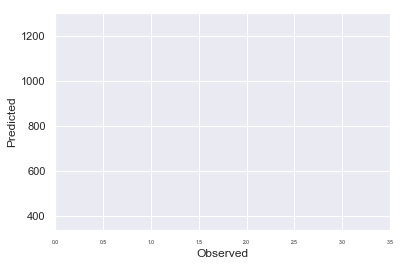

In [153]:
# Test set predictions
print('R2', r2_score(y_test, y_pred))
print('MSE', mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test)
plt.xlim(0, 3.5)
plt.ylabel('Predicted'); plt.xlabel('Observed');

In [157]:
len(y_pred)

9

# Sameple too small for romane only and the regression score not good.  Try Iceburg
#T

In [158]:
df_final_iceburg=df_merged[df_merged['current_crop']=='lettuce_iceburg']
df_final_iceburg.shape

(107, 511)

In [159]:
df_final_iceburg=df_merged[df_merged['current_crop']=='lettuce_iceburg']
df_final_iceburg
X_final_iceburg=pd.concat([df_final_iceburg.iloc[:,1:501]]
            ,axis=1,sort=False)
X_final_iceburg.head(3)
y=df_final_iceburg['yields']

In [160]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(X_final_romane, y,  random_state = 0)

X=X_final_iceburg

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Random forest model....
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2 -0.15425002054554748
MSE 28172.135588754896


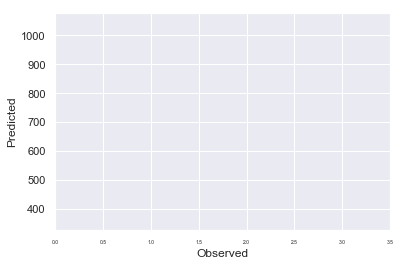

In [161]:
# Test set predictions
print('R2', r2_score(y_test, y_pred))
print('MSE', mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test)
plt.xlim(0, 3.5)
plt.ylabel('Predicted'); plt.xlabel('Observed');

# What DNA should we avoid for bad crops? 


In [176]:
df_merged['bad_yield'] = df_merged['yields'].map(lambda x: 1 if (x < 600) else 0)

In [181]:
df_final_bad_yield=pd.concat([df_merged.iloc[:,1:501],df_merged['bad_yield']]
            ,axis=1,sort=False)

In [182]:
df=df_final_bad_yield
df_minority = df[df['bad_yield'] == 1]
df_majority = df[df['bad_yield'] == 0]
print(len(df_minority),len(df_majority))

62 89


In [183]:
df_majority_downsampled = df_majority.sample(
                                 replace=False,    # sample without replacement
                                 n=len(df_minority), # to match minority class
                                 random_state=42) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

y=df_downsampled['bad_yield']
X=df_downsampled.copy()
del X['bad_yield'] 

In [184]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [186]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor


logModel = LogisticRegression(random_state = 42)
logModel.fit(X_train, y_train)
y_pred = logModel.predict(X_test)
print(classification_report(y_test, y_pred), accuracy_score(y_test, y_pred))


rfModel = RandomForestClassifier(random_state = 42)
rfModel.fit(X_train, y_train)
y_pred = rfModel.predict(X_test)
print(classification_report(y_test, y_pred), accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.38      0.46        21
           1       0.46      0.65      0.54        17

   micro avg       0.50      0.50      0.50        38
   macro avg       0.51      0.51      0.50        38
weighted avg       0.52      0.50      0.49        38
 0.5
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        21
           1       0.53      0.53      0.53        17

   micro avg       0.58      0.58      0.58        38
   macro avg       0.57      0.57      0.57        38
weighted avg       0.58      0.58      0.58        38
 0.5789473684210527


/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


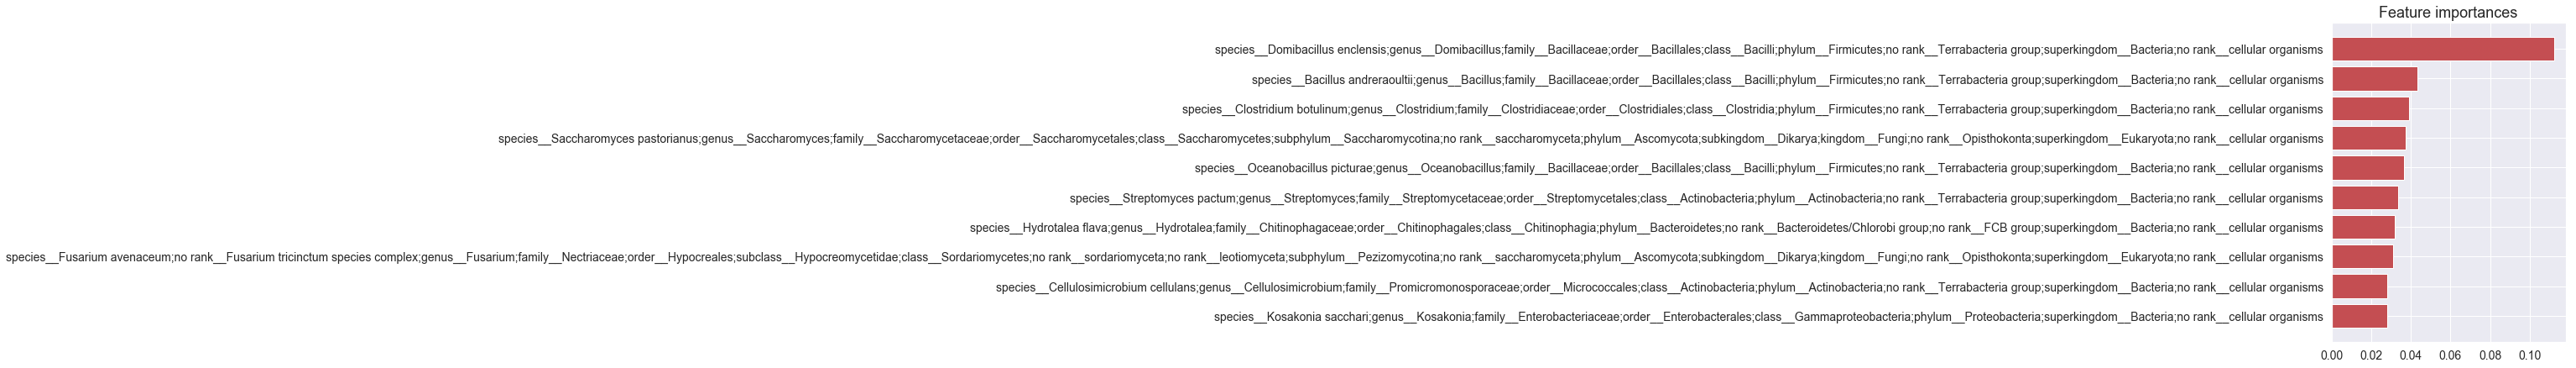

In [199]:
features=df_final_bad_yield.columns
importance = forest.feature_importances_
idx = np.argsort(importance)
indices=idx[-10:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

In [200]:
features[indices]

Index(['species__Kosakonia sacchari;genus__Kosakonia;family__Enterobacteriaceae;order__Enterobacterales;class__Gammaproteobacteria;phylum__Proteobacteria;superkingdom__Bacteria;no rank__cellular organisms',
       'species__Cellulosimicrobium cellulans;genus__Cellulosimicrobium;family__Promicromonosporaceae;order__Micrococcales;class__Actinobacteria;phylum__Actinobacteria;no rank__Terrabacteria group;superkingdom__Bacteria;no rank__cellular organisms',
       'species__Fusarium avenaceum;no rank__Fusarium tricinctum species complex;genus__Fusarium;family__Nectriaceae;order__Hypocreales;subclass__Hypocreomycetidae;class__Sordariomycetes;no rank__sordariomyceta;no rank__leotiomyceta;subphylum__Pezizomycotina;no rank__saccharomyceta;phylum__Ascomycota;subkingdom__Dikarya;kingdom__Fungi;no rank__Opisthokonta;superkingdom__Eukaryota;no rank__cellular organisms',
       'species__Hydrotalea flava;genus__Hydrotalea;family__Chitinophagaceae;order__Chitinophagales;class__Chitinophagia;phylum__B